In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.set_default_dtype(torch.float64)

In [2]:
class DNN(nn.Module):
    def __init__(self, neurons, activation, spectral=False):
        super(DNN, self).__init__()
        self.activation = activation
        self.n_layers = len(neurons)
        self.dense = {}
        self.nn_layers = nn.ModuleList()

        for i in range(self.n_layers-1):
            self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1])
            self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1])
            nn.init.xavier_uniform_(self.dense[str(i)].weight)
            nn.init.zeros_(self.dense[str(i)].bias)
            self.nn_layers.append(self.dense[str(i)])
            
    def forward(self, *args):
        x = torch.cat(args,1)
        activation = self.activation
        for i in range(self.n_layers-2):
            x = activation(self.dense[str(i)](x))
        i = self.n_layers-2
        return self.dense[str(i)](x)

In [3]:
device='cuda'
torch.manual_seed(0)
N_test = 20000
m_test = 201
dim_x = 1
dim_z = 10
x_test = torch.linspace(-1,1,m_test,device=device).reshape(-1,1)
z_test = torch.randn([N_test,dim_z],device=device)

B_size=64

In [4]:
p=64
net_size_Gx = [B_size,64,64,p]
net_size_Gz = [B_size,64,64,p]

def FEx(x):
    x_sin = torch.sin(torch.matmul(x,B_x))
    x_cos = torch.cos(torch.matmul(x,B_x))
    return torch.concat([x_cos,x_sin],-1)

def FEz(x):
    x_sin = torch.sin(torch.matmul(x,B_z))
    x_cos = torch.cos(torch.matmul(x,B_z))
    return torch.concat([x_cos,x_sin],-1)

oGx = DNN(net_size_Gx, activation=torch.tanh).to(device)
oGz = DNN(net_size_Gx, activation=torch.tanh).to(device)

Gx = torch.compile(oGx)
Gz = torch.compile(oGz)

acti = torch.tanh
def G(X, Z):
    X = FEx(X)
    Z = FEz(Z)
    outx = acti(Gx(X))
    outz = Gz(Z)
    out = torch.matmul(outz,outx.T)
    return out

save_path='WGANSN_PCN'
with open(save_path+'/B_x.pickle', 'rb') as f:
    B_x = pickle.load(f)
with open(save_path+'/B_z.pickle', 'rb') as f:
    B_z = pickle.load(f)
Gx.load_state_dict(torch.load(save_path+'/paramsGx'))
Gz.load_state_dict(torch.load(save_path+'/paramsGz'))

with torch.no_grad():
    k_gen = G(x_test, z_test).cpu()
    k_mean_PCN_WGAN, k_std_PCN_WGAN = k_gen.mean(0), k_gen.std(0)
    
    
save_path='GAN_PCN'
with open(save_path+'/B_x.pickle', 'rb') as f:
    B_x = pickle.load(f)
with open(save_path+'/B_z.pickle', 'rb') as f:
    B_z = pickle.load(f)
Gx.load_state_dict(torch.load(save_path+'/paramsGx'))
Gz.load_state_dict(torch.load(save_path+'/paramsGz'))

with torch.no_grad():
    k_gen = G(x_test, z_test).cpu()
    k_mean_PCN_GAN, k_std_PCN_GAN = k_gen.mean(0), k_gen.std(0)

In [5]:
net_size_G = [B_size+dim_z,64,64,64,1]

def FEx(x):
    x_sin = torch.sin(torch.matmul(x,B_x))
    x_cos = torch.cos(torch.matmul(x,B_x))
    return torch.concat([x_cos,x_sin],-1)

oG = DNN(net_size_G, activation=torch.tanh).to(device)
G_FC = torch.compile(oG)

def G(X, Z):
    xsize=X.shape[0]
    zsize=Z.shape[0]
    
    X = X.repeat([zsize,1]).reshape(-1,dim_x)
    Z = Z.repeat([1,xsize]).reshape(-1,dim_z)
    
    X = FEx(X)
    return G_FC(X,Z).reshape(zsize,xsize)

save_path='WGANSN_FCN'
with open(save_path+'/B_x.pickle', 'rb') as f:
    B_x = pickle.load(f)
G_FC.load_state_dict(torch.load(save_path+'/paramsG'))
with torch.no_grad():
    k_gen = G(x_test, z_test).cpu()
    k_mean_FCN_WGAN, k_std_FCN_WGAN = k_gen.mean(0), k_gen.std(0)
    
save_path='GAN_FCN'
with open(save_path+'/B_x.pickle', 'rb') as f:
    B_x = pickle.load(f)
G_FC.load_state_dict(torch.load(save_path+'/paramsG'))
with torch.no_grad():
    k_gen = G(x_test, z_test).cpu()
    k_mean_FCN_GAN, k_std_FCN_GAN = k_gen.mean(0), k_gen.std(0)

In [6]:
colors_ = [plt.cm.Paired(i) for i in range(20)]
x_test_ = x_test.flatten().cpu()

ref_mean = torch.sin(torch.pi*x_test_)
ref_std = 0.3*torch.ones_like(x_test_)
color_ref = 'k'

means = [k_mean_FCN_GAN, k_mean_PCN_GAN, k_mean_FCN_WGAN, k_mean_PCN_WGAN]
stds = [k_std_FCN_GAN, k_std_PCN_GAN, k_std_FCN_WGAN, k_std_PCN_WGAN]
colors = [colors_[1],colors_[5],colors_[8],colors_[14]]
labels = ['FCN_GAN', 'PCN_GAN', 'FCN_WGANSN', 'PCN_WGANSN']
linetypes = ['--', ':', '--', ':']

er_means = []
er_stds = []
for i in range(4):
    print(labels[i])
    er_means.append(torch.norm(means[i]-ref_mean)/torch.norm(ref_mean))
    er_stds.append(torch.norm(stds[i]-ref_std)/torch.norm(ref_std))

FCN_GAN
PCN_GAN
FCN_WGANSN
PCN_WGANSN


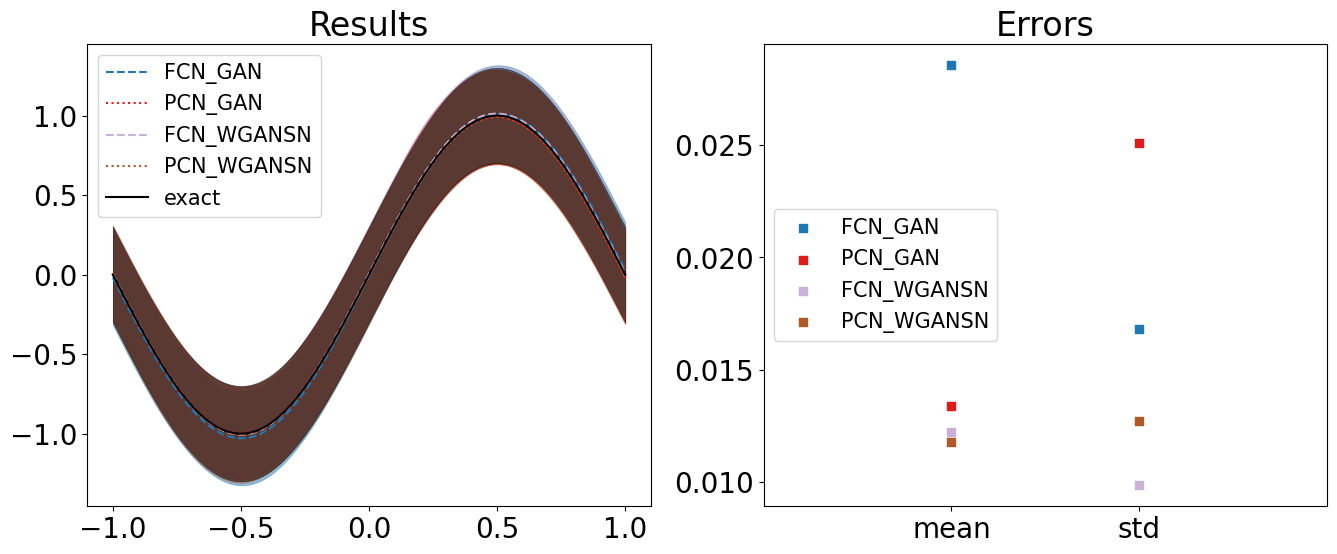

In [7]:
fig = plt.figure(figsize=(16,6))
# axes = [plt.subplot(2,1,1), plt.subplot(2,2,3), plt.subplot(2,2,4)]
axes = [plt.subplot(1,2,1), plt.subplot(1,2,2)]

for i in range(4):
    axes[0].plot(x_test_,means[i],linetypes[i],label=labels[i], color=colors[i])
    axes[0].fill_between(x_test_, means[i]+stds[i], means[i]-stds[i], alpha=0.5, linewidth=.5, color=colors[i])

axes[0].plot(x_test_.flatten(),ref_mean, '-',label='exact', color=color_ref)
axes[0].fill_between(x_test_, ref_mean+ref_std, ref_mean-ref_std, alpha=0.5, linewidth=.5, color=color_ref)
axes[0].legend(fontsize="15")
axes[0].set_title('Results')

for i in range(4):
    axes[1].scatter(0,er_means[i],marker='s',label=labels[i],color=colors[i])
    axes[1].scatter(1,er_stds[i],marker='s',color=colors[i])
axes[1].legend(fontsize="15")
axes[1].set_title('Errors')
axes[1].set_xlim([-1,2])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['mean','std'])
fig.show()
fig.savefig('images/GPresults.pdf',bbox_inches='tight')


In [ ]:
!kill -9 {os.getpid()}